<a href="https://colab.research.google.com/github/claubermartins/Stock-market-prediction-FII/blob/master/Stock-market-prediction-FII-GTWR11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install inflection

#**1-Importando bibliotecas**

In [2]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import seaborn as sns
import datetime
import inflection
from IPython.core.display import HTML

#**2-Funções auxiliares para o Jupyter Notebook**

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


##**2.1Método de importação de arquivos do Google Colab**

In [5]:
from google.colab import files
upload = files.upload()
print("downloaded files: ")
print(*upload, sep = "\n")

Saving GTWR11_teste.csv to GTWR11_teste.csv
Saving GTWR11_treinamento.csv to GTWR11_treinamento.csv
downloaded files: 
GTWR11_teste.csv
GTWR11_treinamento.csv


#**3-Tratamento dos dados**

##**3.1-Importando os dados**

In [7]:
base = pd.read_csv('GTWR11_treinamento.csv')
base = base.drop('Date', axis = 1)

In [8]:
#valores estatísticos
base.describe()

,Open,High,Low,Close,Adj Close,Volume
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,87.500987,88.408092,86.310263,87.402171,87.402171,13673.388158
std,9.710784,9.589653,9.687412,9.659429,9.659429,9104.002127
min,69.089996,69.099998,68.099998,69.050003,69.050003,3028.000000
25%,81.885002,82.877499,80.000000,81.809997,81.809997,8105.000000
50%,88.025002,88.974998,86.535000,87.850003,87.850003,12116.000000
75%,94.727501,95.125000,92.440001,94.620001,94.620001,15894.000000
max,105.000000,105.370003,103.669998,104.230003,104.230003,59165.000000


In [9]:
base.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

##**3.2-Tratando os Valores Faltantes**

In [10]:
#valores faltantes
base.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
#encontrando onde os valores faltantes estão
base.loc[pd.isnull(base['Open'])]
base.loc[pd.isnull(base['High'])]
base.loc[pd.isnull(base['Low'])]
base.loc[pd.isnull(base['Close'])]
base.loc[pd.isnull(base['Adj Close'])]
base.loc[pd.isnull(base['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


In [12]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=0)
imputer = imputer.fit(base.iloc[:,0:6])
base.iloc[:,0:6] = imputer.transform(base.iloc[:,0:6])

In [13]:
#verificando novamente se ainda temos valores faltantes
base.loc[pd.isnull(base['Open'])]
base.loc[pd.isnull(base['High'])]
base.loc[pd.isnull(base['Low'])]
base.loc[pd.isnull(base['Close'])]
base.loc[pd.isnull(base['Adj Close'])]
base.loc[pd.isnull(base['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


##**3.3-Tratamento dos valores nulos (iguais a 0)**

In [14]:
#valores nulos
(base == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [15]:
#Encontrando os valores nulos
base.loc[base['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [16]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=0, strategy='mean',verbose=0)
imputer = imputer.fit(base.iloc[:,0:6])
base.iloc[:,0:6] = imputer.transform(base.iloc[:,0:6])

In [17]:
#Verificando novamente se ainda temos valores nulos
base.loc[base['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [18]:
#base = base.dropna()

In [19]:
#base.sample()

#**-Descrição dos dados** IGNORE ESTA CÉLULA

In [ ]:
#Tendencia central - mean, median
ct1 = pd.DataFrame(base.apply(np.mean)).T #T transpondo 
ct2 = pd.DataFrame(base.apply(np.median)).T
#Dispersão - std(desvio padrão), min, max, range
d1 = pd.DataFrame(base.apply(np.std)).T
d2 = pd.DataFrame(base.apply(min)).T
d3 = pd.DataFrame(base.apply(max)).T
d4 = pd.DataFrame(base.apply(lambda x: x.max() - x.min())).T
#concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1]).T.reset_index()
m.columns = ['attributes','min','max','range', 'mean', 'median', 'std']
m

In [ ]:
base.shape[0]

2478

#**4-Treinamento da rede**

In [20]:
#normalizando a base de dados com o MinMaxScaler
base_treinamento = base.iloc[:, 0:6].values
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [21]:
#Comparando a predição com o preço real
previsores = []
preco_real = []
for i in range(90, 152):
    previsores.append(base_treinamento_normalizada[i-90:i, 0:6])
    preco_real.append(base_treinamento_normalizada[i, 3:4])
previsores, preco_real = np.array(previsores), np.array(preco_real)


In [22]:
#estrutura da rede neural 
regressor = Sequential()
regressor.add(LSTM(units = 128, return_sequences = True, input_shape = (previsores.shape[1], 6)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'loss', min_delta = 1e-15, patience = 20, verbose = 1)

#regressor.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
#                  metrics = ['mean_absolute_error'])
opt = tf.keras.optimizers.Adam(amsgrad=True)
regressor.compile(optimizer = opt, loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])
#opt = tf.keras.optimizers.RMSprop(centered=True)
#regressor.compile(optimizer = opt, loss = 'mean_squared_error',
#                 metrics = ['mean_absolute_error'])

regressor.fit(previsores, preco_real, epochs = 600, batch_size = 32,
              callbacks = [es])
#regressor.fit(previsores, preco_real, epochs = 600, batch_size = 32)

Epoch 1/600
2/2 [==============================] - 13s 92ms/step - loss: 0.0830 - mean_absolute_error: 0.2312
Epoch 2/600
2/2 [==============================] - 0s 93ms/step - loss: 0.0569 - mean_absolute_error: 0.1894
Epoch 3/600
2/2 [==============================] - 0s 91ms/step - loss: 0.0306 - mean_absolute_error: 0.1500
Epoch 4/600
2/2 [==============================] - 0s 94ms/step - loss: 0.0314 - mean_absolute_error: 0.1518
Epoch 5/600
2/2 [==============================] - 0s 91ms/step - loss: 0.0374 - mean_absolute_error: 0.1655
Epoch 6/600
2/2 [==============================] - 0s 95ms/step - loss: 0.0258 - mean_absolute_error: 0.1405
Epoch 7/600
2/2 [==============================] - 0s 90ms/step - loss: 0.0285 - mean_absolute_error: 0.1533
Epoch 8/600
2/2 [==============================] - 0s 93ms/step - loss: 0.0289 - mean_absolute_error: 0.1491
Epoch 9/600
2/2 [==============================] - 0s 91ms/step - loss: 0.0254 - mean_absolute_error: 0.1382
Epoch 10/600
2/2 [

#**5-Teste da rede**

##**5.1-Importando os dados para teste**

In [23]:
#criando a base de dados teste
base_teste = pd.read_csv('GTWR11_teste.csv')
base_teste = base_teste.drop('Date', axis = 1)

In [24]:
#valores estatísticos
base_teste.describe()

,Open,High,Low,Close,Adj Close,Volume
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,80.433333,81.229583,79.653750,80.263333,80.263333,7759.041667
std,1.726508,1.775089,1.519395,1.698764,1.698764,3316.217390
min,77.629997,78.250000,77.300003,77.620003,77.620003,2843.000000
25%,79.014998,79.770001,78.270001,78.837502,78.837502,5629.000000
50%,80.160000,81.104999,79.750000,80.254998,80.254998,6942.500000
75%,81.992498,82.745001,80.829998,81.395000,81.395000,9746.750000
max,83.290001,83.959999,82.540001,83.080002,83.080002,16788.000000


##**5.2-Tratando os Valores Faltantes**

In [25]:
#valores faltantes
base_teste.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [26]:
#encontrando onde os valores faltantes estão
base_teste.loc[pd.isnull(base_teste['Open'])]
base_teste.loc[pd.isnull(base_teste['High'])]
base_teste.loc[pd.isnull(base_teste['Low'])]
base_teste.loc[pd.isnull(base_teste['Close'])]
base_teste.loc[pd.isnull(base_teste['Adj Close'])]
base_teste.loc[pd.isnull(base_teste['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


In [27]:
#preenchendo os valores faltantes com o valor médio
imputer = SimpleImputer(missing_values=np.nan, strategy='mean',verbose=0)
imputer = imputer.fit(base_teste.iloc[:,0:6])
base_teste.iloc[:,0:6] = imputer.transform(base_teste.iloc[:,0:6])

In [28]:
#verificando novamente se ainda temos valores faltantes
base_teste.loc[pd.isnull(base_teste['Open'])]
base_teste.loc[pd.isnull(base_teste['High'])]
base_teste.loc[pd.isnull(base_teste['Low'])]
base_teste.loc[pd.isnull(base_teste['Close'])]
base_teste.loc[pd.isnull(base_teste['Adj Close'])]
base_teste.loc[pd.isnull(base_teste['Volume'])]

,Open,High,Low,Close,Adj Close,Volume


##**5.3-Tratamento dos valores nulos (iguais a 0)**

In [29]:
#valores nulos
(base_teste == 0).sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [30]:
#Encontrando os valores nulos
base_teste.loc[base_teste['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


In [31]:
#preenchendo os valores nulos com o valor médio
imputer = SimpleImputer(missing_values=0, strategy='mean',verbose=0)
imputer = imputer.fit(base_teste.iloc[:,0:6])
base_teste.iloc[:,0:6] = imputer.transform(base_teste.iloc[:,0:6])

In [32]:
#Verificando novamente se tem valores nulos
base_teste.loc[base_teste['Volume'] == 0]

,Open,High,Low,Close,Adj Close,Volume


##**5.4-Preparando a estrutura para teste**

In [34]:
#concatenando a base de dados teste com o base de treinamento
preco_real_teste = base_teste.iloc[:, 3:4].values
frames = [base, base_teste]
base_completa = pd.concat(frames)

In [35]:
#pegando os 90 registros anteriores para percorrer a base teste e colocando no
#no formato np.array
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = normalizador.transform(entradas)
Percorrer_teste = []
for i in range(90, 114): 
    Percorrer_teste.append(entradas[i-90:i, 0:6])
Percorrer_teste = np.array(Percorrer_teste)

In [36]:
#resultado da predição no formato MinMaxScaler
previsoes = regressor.predict(Percorrer_teste)

In [37]:
#convertendo para a escala MinMaxScaler 
normalizador_previsao = MinMaxScaler(feature_range=(0,1))
normalizador_previsao.fit_transform(base_treinamento[:,3:4])

array([[1.        ],
       [0.97924949],
       [0.94314952],
       [0.84280824],
       [0.89653192],
       [0.90250142],
       [0.84707206],
       [0.84906182],
       [0.8308697 ],
       [0.82376339],
       [0.82831151],
       [0.82575313],
       [0.87578164],
       [0.90108007],
       [0.91529269],
       [0.90989184],
       [0.90761796],
       [0.88402499],
       [0.93604321],
       [0.90449119],
       [0.90420688],
       [0.90221711],
       [0.90818638],
       [0.90108007],
       [0.89368945],
       [0.9019328 ],
       [0.90449119],
       [0.88317226],
       [0.86753829],
       [0.83570193],
       [0.84479801],
       [0.82291066],
       [0.82546882],
       [0.80130742],
       [0.79420111],
       [0.78169414],
       [0.75184756],
       [0.66372936],
       [0.6489481 ],
       [0.62677644],
       [0.66401367],
       [0.64866401],
       [0.63501978],
       [0.64440017],
       [0.65406467],
       [0.67509949],
       [0.63814659],
       [0.686

In [38]:
#colocando a previsão no formato original para preparar a visualização no gráfico
previsoes = normalizador_previsao.inverse_transform(previsoes)
previsoes

array([[83.62832 ],
       [83.55975 ],
       [83.4859  ],
       [83.40461 ],
       [83.31354 ],
       [83.21059 ],
       [83.09268 ],
       [82.956924],
       [82.8009  ],
       [82.62188 ],
       [82.41711 ],
       [82.18462 ],
       [81.92332 ],
       [81.63384 ],
       [81.31944 ],
       [80.98477 ],
       [80.63613 ],
       [80.27967 ],
       [79.922455],
       [79.568924],
       [79.22438 ],
       [78.89086 ],
       [78.57118 ],
       [78.26855 ]], dtype=float32)

#**6-Análise dos resuldatos**

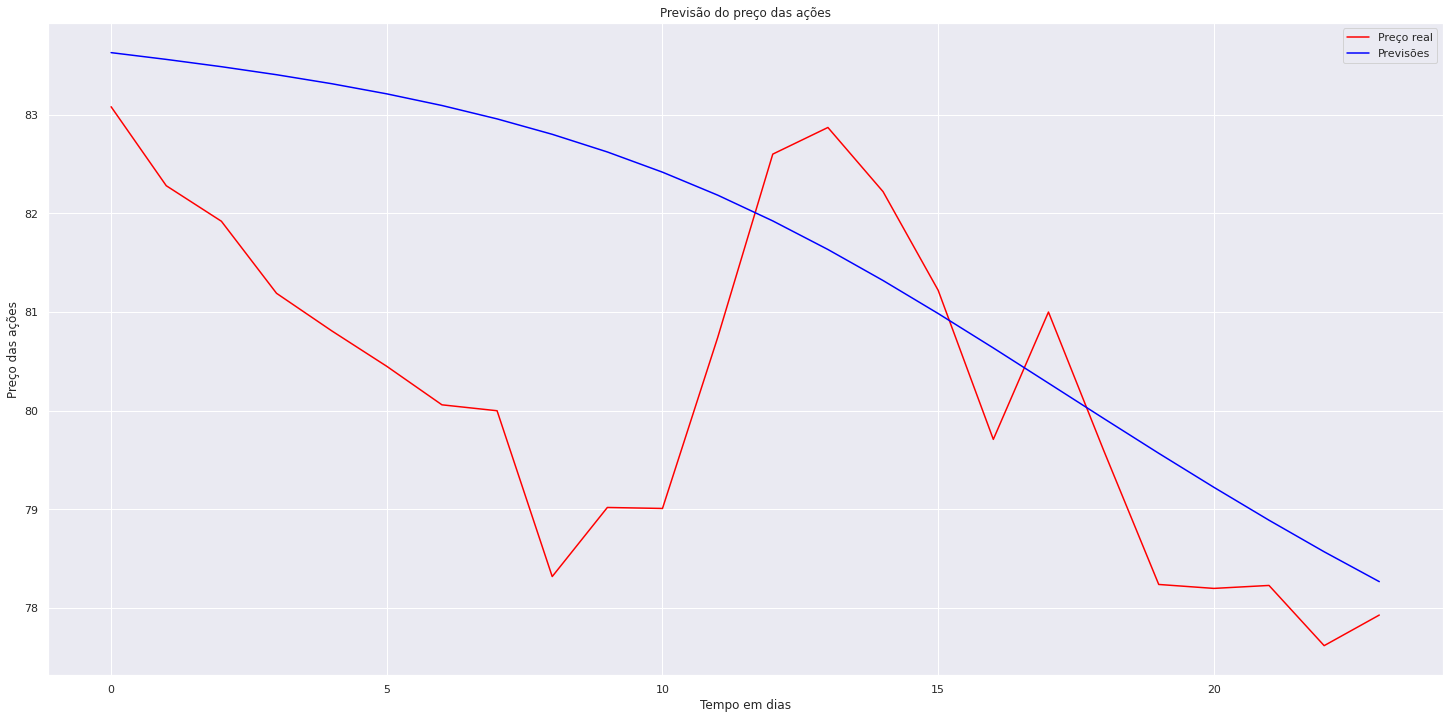

In [39]:
#Visualizando o gráfico da Previsão da rede
plt.plot(preco_real_teste, color = 'red', label = 'Preço real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão do preço das ações')
plt.xlabel('Tempo em dias')
plt.ylabel('Preço das ações')
plt.legend()
plt.show()

In [40]:
#estatísticas do preço real comparado com a previsão
df1 = pd.DataFrame(preco_real_teste).T
df2 = pd.DataFrame(previsoes).T

df3 = pd.concat([df1,df2]).T
df3.columns = ['Preco real', 'Previsoes']
df3.describe()

,Preco real,Previsoes
count,24.000000,24.000000
mean,80.263333,81.579181
std,1.698764,1.760471
min,77.620003,78.268547
25%,78.837502,80.190367
50%,80.254998,82.053970
75%,81.395000,83.122158
max,83.080002,83.628319


In [ ]:
#df2 = pd.DataFrame(previsoes)
#df2.describe()

In [ ]:
#df1 = pd.DataFrame(preco_real_teste)
#df1.describe()